In [1]:
print("all")

all


In [8]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

In [4]:
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

In [12]:
llm = ChatGroq(model="openai/gpt-oss-20b",max_tokens=250)
llm.invoke("hi").content

'Hello! How can I help you today?'

In [18]:
from typing import List,Annotated,TypedDict
import operator
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage,AnyMessage
from langgraph.graph import StateGraph


In [15]:
class GraphState(TypedDict):
    messages:Annotated[List[AnyMessage],operator.add]

In [16]:
def llm_call(state:GraphState)->dict:
    """Call the LLM using conversation messages and append AI response to the messages."""
    response=llm.invoke(state['messages'])
    return {
        "messages":[response]
    }

In [23]:
def token_counter(state:GraphState)->dict:
    """Count the number of tokens in the conversaiton messages."""
    last_message=state['messages'][-1]
    text=last_message.content
    token_count=len(text.split(" "))
    summary=f"Count of the generated answer is {token_count} tokens."
    return {
        "messages":[AIMessage(content=summary)]
    }

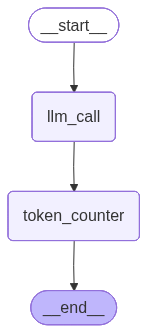

In [24]:
builder=StateGraph(GraphState)
builder.add_node('llm_call',llm_call)
builder.add_node('token_counter',token_counter)

builder.set_entry_point('llm_call')
builder.add_edge('llm_call','token_counter')
builder.set_finish_point('token_counter')

builder.compile()

In [26]:
app=builder.compile()

In [34]:
result=app.invoke({"messages":[HumanMessage(content="hi how are you?")]})

In [39]:
for message in result['messages']:
    print(type(message).__name__+" : "+ message.content)

HumanMessage : hi how are you?
AIMessage : Hello! I'm just a bundle of code, so I don't have feelings, but I'm here and ready to help. How can I assist you today?
AIMessage : Count of the generated answer is 25 tokens.


In [40]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [42]:
api_wrapper=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [44]:
wiki_tool.run({"query":"what is car?"})

'Page: What the Car?\nSummary: What the Car? (stylized in all caps) is a 2023 video game developed and published by Triband. It was originally released for iOS, macOS and tvOS via Apple Arcade in 2023 and in September 2024 for Windows. Players control a car to guide it the end of a series of levels in parodies of multiple genres, with its methods of movement and control changing in unexpected and comic ways.\nTriband intended the game to be a follow-up to What the Golf?, with the objective of creat'

In [45]:
wiki_tool.invoke("what is bike?")

"Page: Law of triviality\nSummary: The law of triviality is C. Northcote Parkinson's 1957 argument that people within an organization commonly give disproportionate weight to trivial issues. Parkinson provides the example of a fictional committee whose job was to approve the plans for a nuclear power plant spending the majority of its time on discussions about relatively minor but easy-to-grasp issues, such as what materials to use for the staff bicycle shed, while neglecting the proposed design o"

In [47]:
load_dotenv()
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
from langchain_community.tools.tavily_search import TavilySearchResults

In [49]:
tavily_tool=TavilySearchResults(max_results=2)
tavily_tool.run("what is python?")

[{'title': "What Is Python Used For? A Beginner's Guide - Coursera",
  'url': 'https://www.coursera.org/articles/what-is-python-used-for-a-beginners-guide-to-using-python',
  'content': "In this article, you'll learn more about what Python is and how it's used in the real world. If you want to start learning this popular programming language today, consider enrolling in the University of Michigan's Python for Everybody Specialization where you'll build foundational programming knowledge in as little as two months.\n\n## What is Python?\n\nPython is a computer programming language often used to build websites and software, automate tasks, and conduct data analysis. Python is a general-purpose language, meaning it can be used to create a variety of different programs and isn’t specialized for any specific problems. This versatility, along with its beginner-friendliness, has made it one of the most-used programming languages today. [...] # What Is Python Used For? A Beginner’s Guide\n\nWr

In [50]:
from langchain_core.tools import tool

In [51]:
@tool
def multiply(a:int,b:int)->int:
    """Tool to Multiply two numbers"""
    return a*b

In [54]:
multiply.invoke({"a":5,"b":10})

50

In [55]:
@tool
def get_word_length(word:str)->int:
    """Tool to count the number of characters in a word."""
    return len(word)

In [117]:
tools=[wiki_tool,tavily_tool,multiply,get_word_length]


In [57]:
tool_bind_llm=llm.bind_tools(tools)

In [64]:
result=tool_bind_llm.invoke("what is the length of the word encyclopedia ?")

In [66]:
result.tool_calls

[{'name': 'get_word_length',
  'args': {'word': 'encyclopedia'},
  'id': 'fc_f8227a1e-c48f-4953-81ee-59f446823535',
  'type': 'tool_call'}]

In [102]:
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.prebuilt import ToolNode,tools_condition

In [140]:
SYSTEM_PROMPT="You are a helpful assistant that can answer questions using only the tools provided to you. " \
"If the question does not have a reated tool to answer which is binded ,Just say you dont know how to answer that question."

In [141]:
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\user\\Python Programs\\Gen AI\\Krish Naik course\\AI Agents\\env\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=2, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 StructuredTool(name='multiply', description='Multiply two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001B5F0EBE840>),
 StructuredTool(name='get_word_length', description='Tool to count the number of characters in a word.', args_schema=<class 'langchain_core.utils.pydantic.get_word_length'>, func=<function get_word_length at 0x000001B5F1275300>)]

In [142]:
def llm_node(state:MessagesState):
    """Call the LLM with tools bound."""
    query=[SYSTEM_PROMPT]+state['messages']
    response = tool_bind_llm.invoke(query)
    return {"messages": [response]}

tool_node = ToolNode(tools=tools)

In [143]:
workflow=StateGraph(MessagesState)

In [144]:
workflow.add_node('llm_node',llm_node)
workflow.add_node('tools',tool_node)

In [145]:
workflow.add_edge(START,'llm_node')
workflow.add_conditional_edges('llm_node',tools_condition)
workflow.add_edge('tools','llm_node')

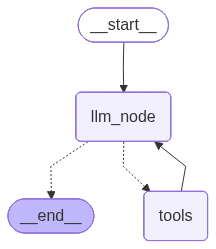

In [146]:
workflow.compile()

In [147]:
app1=workflow.compile()

In [159]:
response=app1.invoke({"messages":[HumanMessage(content="what is lcm of 5 and 10 ?")]})

In [160]:
for msg in response['messages']:
    msg.pretty_print()


================================ Human Message =================================

what is lcm of 5 and 10 ?
================================== Ai Message ==================================

The least common multiple (LCM) of 5 and 10 is **10**.
